# CS3244 Project Pg34:
### Baseline CT - Augmented FVC forecasting to project pulmonary fibrosis progression, aiding medical decision-making and prognosis

Insert brief introduction here

### Imports:

Package imports:

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression


Tabular data import:

In [ ]:
BASE_DIR = Path.cwd()
csv_path = BASE_DIR / "data" / "train.csv"

data = pd.read_csv(csv_path)
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


## Exploratory Data Analysis/ Image Data Preprocessing

### Tabular Data

Here is the outline of what each columns represent:  
Patient(str): unique ID for each patient  
Weeks(int): the relative number of weeks pre/post the baseline CT scan  
FVC(int): the recorded lung capacity in ml  
Percent(float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics  
Age(int), Sex(str), SmokingStatus(str)

For now, FVC readings measured pre-CT scans are dropped, then readings are grouped by patient IDs.

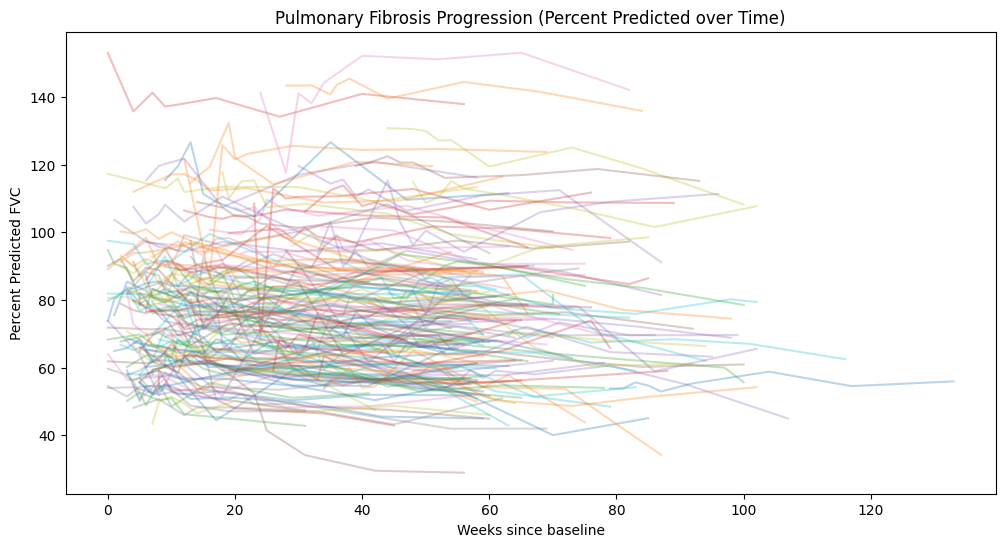

In [3]:
post_CT_data = data[data["Weeks"]>=0]
plt.figure(figsize=(12, 6))

for patient, pdata in post_CT_data.groupby("Patient"):
    plt.plot(pdata["Weeks"], pdata["Percent"], alpha=0.3)

plt.xlabel("Weeks since baseline")
plt.ylabel("Percent Predicted FVC")
plt.title("Pulmonary Fibrosis Progression (Percent Predicted over Time)")
plt.show()

Overall linear trend of decreasing percent values is observed. Now, effect of age is assessed, but there is a limitation: the readings are taken irregularly, so it is challenging to compute a metric that expresses change in FVC from week 30 to week 0. Instead, a percentage decline is computed then plotted.

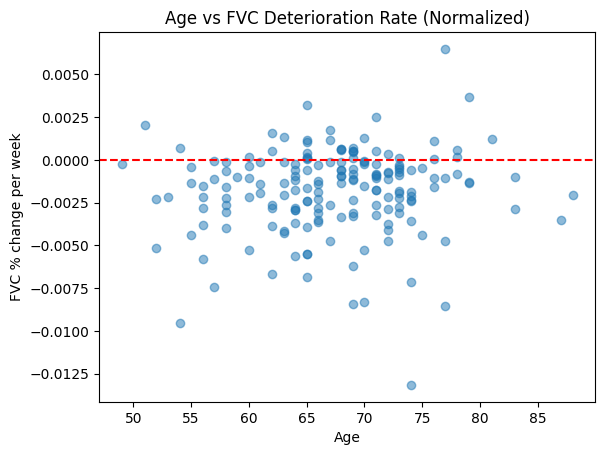

In [4]:
rates = []
ages = []

for patient, pdata in post_CT_data.groupby("Patient"):
    pdata = pdata.sort_values("Weeks")
    fvc_first = pdata["FVC"].iloc[0]
    fvc_last = pdata["FVC"].iloc[-1]
    t_first = pdata["Weeks"].iloc[0]
    t_last = pdata["Weeks"].iloc[-1]
    
    if t_last > t_first:  # avoid divide by zero
        decline_rate = (fvc_last - fvc_first) / (fvc_first * (t_last - t_first))
        rates.append(decline_rate)
        ages.append(pdata["Age"].iloc[0])

plt.scatter(ages, rates, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("FVC % change per week")
plt.title("Age vs FVC Deterioration Rate (Normalized)")
plt.axhline(0, color="red", linestyle="--")
plt.show()

Not much explicit correlation between age and relative FVC decline is shown in this plot. Moving on to sex:

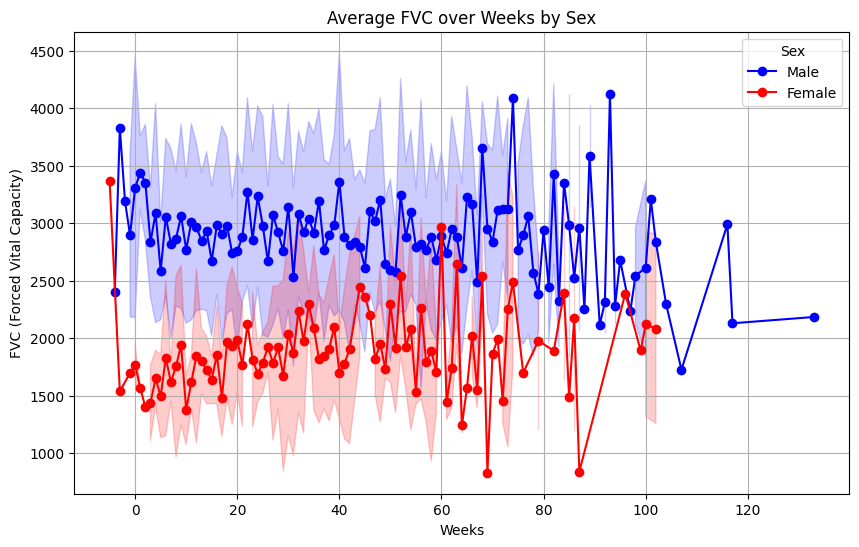

In [5]:
sex_weeks = data.groupby(["Weeks", "Sex"])["FVC"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(10,6))

# Plot Male
male = sex_weeks[sex_weeks["Sex"] == "Male"]
plt.plot(male["Weeks"], male["mean"], label="Male", color="blue", marker="o")
plt.fill_between(male["Weeks"], male["mean"] - male["std"], male["mean"] + male["std"],
                 alpha=0.2, color="blue")

# Plot Female
female = sex_weeks[sex_weeks["Sex"] == "Female"]
plt.plot(female["Weeks"], female["mean"], label="Female", color="red", marker="o")
plt.fill_between(female["Weeks"], female["mean"] - female["std"], female["mean"] + female["std"],
                 alpha=0.2, color="red")

plt.title("Average FVC over Weeks by Sex")
plt.xlabel("Weeks")
plt.ylabel("FVC (Forced Vital Capacity)")
plt.legend(title="Sex")
plt.grid(True)
plt.show()


The blue line (Male) is consistently higher than the red line (Female) which matches expectations since on average, males have larger lung volumes than females due to physiological differences (height, chest size, etc.).

Males (blue band) show larger variability in FVC compared to females. This means some males decline much faster/slower than others, while female patients are more tightly clustered around the average, suggesting more heterogeneity in the disease course of male patients. Most importantly, the rate of decline looks similar for both sexes.

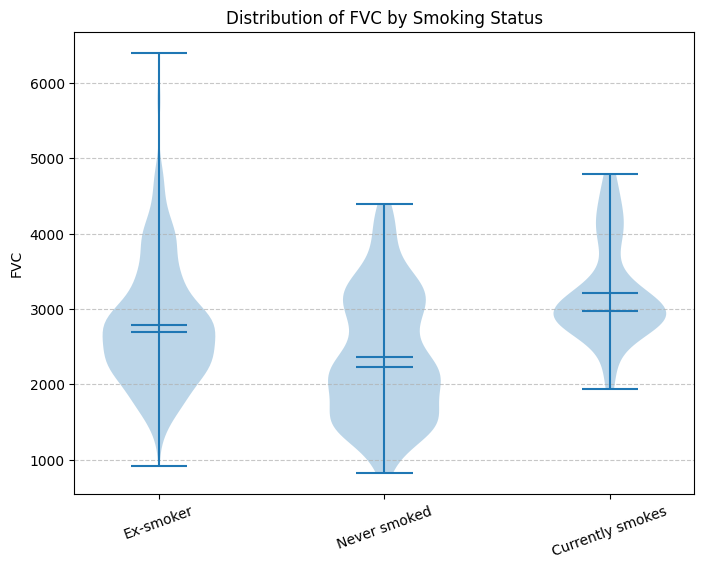

In [6]:
groups = [data.loc[data["SmokingStatus"] == status, "FVC"].dropna() 
          for status in data["SmokingStatus"].unique()]
labels = data["SmokingStatus"].unique()

plt.figure(figsize=(8,6))
plt.violinplot(groups, showmeans=True, showmedians=True)
plt.xticks(range(1, len(labels)+1), labels, rotation=20)
plt.title("Distribution of FVC by Smoking Status")
plt.ylabel("FVC")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()

Patients who currently smoke generally exhibit higher FVC values than those who have never smoked, while ex-smokers show a wider distribution with more variability and some very low values. This suggests that smoking history influences lung function, but the relationship is not entirely linear. Current smokers not always showing the lowest FVC, possibly due to sample variation or confounding factors such as age or disease severity.

### Image Data

## Baseline Unimodal Models

### Tabular Data: XGBoost


For the first baseline model, the longitudinal data is coerced into a single row to be pipelined into a simpler XGBoost model.

In row coercion, linearity is assumed and the grouped dataframe is collapsed by computing three features:
1. $\Delta t$ : the change in time from the second last reading from the first reading
2. $\Delta$ FVC : the change in FVC from the second last reading from the first reading
3. next_time : the change in time from the last reading which is being predicted to the second last reading

Then, the label will be the FVC reading from the last reading.

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   Weeks_scaled  FVC_scaled  Baseline_FVC  
0     -1.510341   -0.448119     -0.448119  
1     -1.122587   -0.566423     -0.448119  
2     -1.036419   -0.745635     -0.448119  
3     -0.950252   -0.648415     -0.448119  
4     -0.864084   -0.736264     -0.448119  
                     Patient  Weeks   FVC     Percent  Age     Sex  \
0  ID00020637202178344345685     18  2297  117.770714   66  Female   
1  ID00020637202178344345685     19  2145  109.977441   66  Female   
2  ID00020637202178344345685     21  22

c:\Coding\pulmonary_fibrosis\models\baseline.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].astype("category")
c:\Coding\pulmonary_fibrosis\models\baseline.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[c] = X_val[c].astype("category")
c:\Coding\pulmonary_fibrosis\models\baseline.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Best CV MAE: 575.2444580078125
Best params: {'colsample_bytree': np.float64(0.8655954783926731), 'learning_rate': np.float64(0.0019751300321548034), 'max_depth': 4, 'min_child_weight': np.float64(5.112595631765099), 'reg_alpha': np.float64(0.07913265420222118), 'reg_lambda': np.float64(0.08136068518030848), 'subsample': np.float64(0.6873053627196668)}
Test MAE: 538.4096069335938
XGBoost Baseline Results:
MAE: 524.0677490234375
R²: 0.23757892847061157


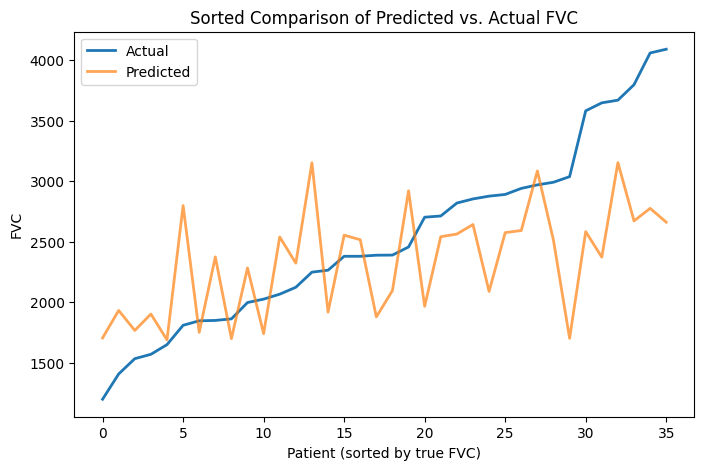

In [7]:
sys.path.insert(0, str(BASE_DIR / "late_fusion"))
from models.baseline import X_train, X_val, y_train, y_val, baseline

# Train the model
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_val)
print(f"XGBoost Baseline Results:")
print("MAE:", mean_absolute_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

order = np.argsort(y_val)
y_true_sorted = np.array(y_val)[order]
y_pred_sorted = np.array(y_pred)[order]

plt.figure(figsize=(8, 5))
plt.plot(y_true_sorted, label="Actual", lw=2)
plt.plot(y_pred_sorted, label="Predicted", lw=2, alpha=0.7)
plt.title("Sorted Comparison of Predicted vs. Actual FVC")
plt.xlabel("Patient (sorted by true FVC)")
plt.ylabel("FVC")
plt.legend()
plt.show()

### Tabular Data: Gaussian Process Regression

For the second baseline model, Gaussian Process (GP) is considered for the following reasons:
1. GP handles longitudinal data well, by modelling the temporal correlation and inter-patient covariance.
2. GP requires a lot less data than neural network and its variants

The initial, simpler attempt involved omitting patient ID and the subsequent inter-patient variance (refer to ./late_fusion/gaussian_process.py). Essentially, data from patients with similar demographic metadata were not differentiated before being passed into the model. 

It did not perform well, and thus the final GP model utilizes patient ID embeddings to capture individual temporal trajectories, but at inference the predictions on deviation of the new patient's FVC values from mean depending on the patient's demographic data.

c:\Coding\pulmonary_fibrosis\.venv\Lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:655.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


RMSE: 0.8331, R²: 0.0833

=== Random Restart 1/5 ===
Iter 500/5000 - Loss: -0.538
Iter 1000/5000 - Loss: -0.571
Iter 1500/5000 - Loss: -0.568
Iter 2000/5000 - Loss: -0.569
Iter 2500/5000 - Loss: -0.571
Iter 3000/5000 - Loss: -0.570
Iter 3500/5000 - Loss: -0.570
Iter 4000/5000 - Loss: -0.572
Iter 4500/5000 - Loss: -0.570
Iter 5000/5000 - Loss: -0.571
New best loss: -0.571

=== Random Restart 2/5 ===
Iter 500/5000 - Loss: -0.553
Iter 1000/5000 - Loss: -0.570
Iter 1500/5000 - Loss: -0.570
Iter 2000/5000 - Loss: -0.569
Iter 2500/5000 - Loss: -0.569
Iter 3000/5000 - Loss: -0.572
Iter 3500/5000 - Loss: -0.571
Iter 4000/5000 - Loss: -0.571
Iter 4500/5000 - Loss: -0.569
Iter 5000/5000 - Loss: -0.550

=== Random Restart 3/5 ===
Iter 500/5000 - Loss: -0.179
Iter 1000/5000 - Loss: -0.554
Iter 1500/5000 - Loss: -0.566
Iter 2000/5000 - Loss: -0.566
Iter 2500/5000 - Loss: -0.569
Iter 3000/5000 - Loss: -0.566
Iter 3500/5000 - Loss: -0.569
Iter 4000/5000 - Loss: -0.563
Iter 4500/5000 - Loss: -0.569
It

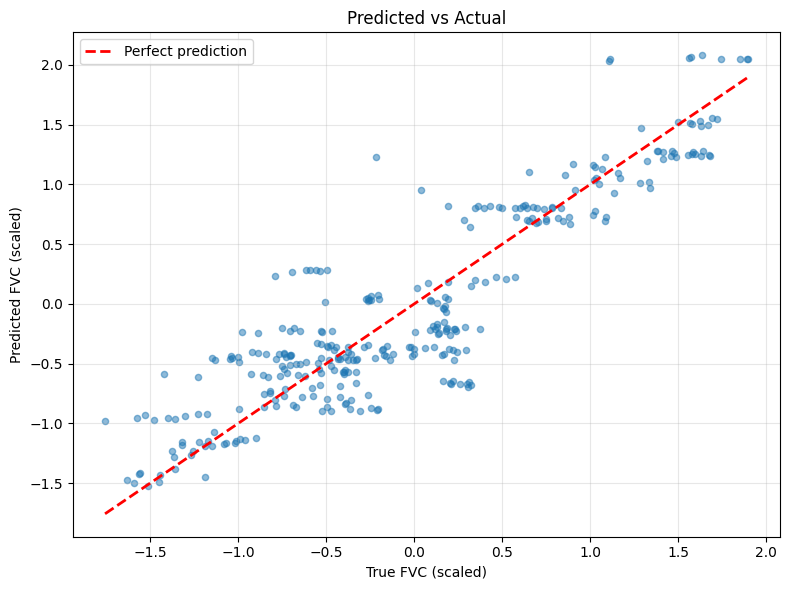

In [8]:
from preprocessing.tabular_preprocessing import train_df, val_df
from models.gaussian_process import *

best_loss = float('inf')
best_model_state = None

for restart in range(5):
    print(f"\n=== Random Restart {restart + 1}/5 ===")
    
    # Reinitialize model and optimizer with random parameters
    likelihood_m2 = GaussianLikelihood()
    M2 = GPM2(X_time_train, X_age_train, X_baseline_train, pid_train, sex_train, smk_train, 
              y_train, likelihood_m2, n_patients, sex_card, smk_card, emb_dim=4)  # Increased to 4
    M2.train()
    likelihood_m2.train()
    optimizer_m2 = torch.optim.Adam(M2.parameters(), lr=0.01)
    mll_m2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_m2, M2)
    
    for i in range(5000):  
        optimizer_m2.zero_grad()
        weeks, age, baseline_fvc, sex, smk = M2.train_inputs 
        output = M2(weeks, age, baseline_fvc, sex, smk, use_patient_effects=True)
        loss = -mll_m2(output, y_train)
        loss.backward()
        optimizer_m2.step()
        
        if (i + 1) % 500 == 0:
            print(f"Iter {i+1}/5000 - Loss: {loss.item():.3f}")
    
    # Check if this restart achieved better loss
    final_loss = loss.item()
    if final_loss < best_loss:
        best_loss = final_loss
        best_model_state = M2.state_dict()
        print(f"New best loss: {best_loss:.3f}")

# Load the best model
likelihood_m2 = GaussianLikelihood()
M2 = GPM2(X_time_train, X_age_train, X_baseline_train, pid_train, sex_train, smk_train, 
          y_train, likelihood_m2, n_patients, sex_card, smk_card, emb_dim=4)  # Increased to 4
M2.load_state_dict(best_model_state)
print(f"\n=== Best model selected with loss: {best_loss:.3f} ===")

M2.eval()
likelihood_m2.eval()  # Fixed: was 'likelihood', should be 'likelihood_m2'

X_time_val = torch.tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_val = torch.tensor(val_df[["Age"]].values, dtype=torch.float32)
X_baseline_val = torch.tensor(val_df[["Baseline_FVC"]].values, dtype=torch.float32)
sex_val = torch.tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val = torch.tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood_m2(M2(X_time_val, X_age_val, X_baseline_val, sex_val, smk_val, 
                         use_patient_effects=False))
    y_pred = pred.mean.numpy()
    y_std = pred.variance.sqrt().numpy()

y_true = val_df["FVC_scaled"].values
residuals = y_true - y_pred

mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
lll = -len(y_true) * np.log(2 * mae) - np.sum(np.abs(residuals) / mae)
print(f"MAE: {mae:.4f}")
print(f"Laplace Log-Likelihood: {lll:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

print(f"R squared: {r2_score(y_true, y_pred)}")

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], 
         [y_true.min(), y_true.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True FVC (scaled)')
plt.ylabel('Predicted FVC (scaled)')
plt.title('Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


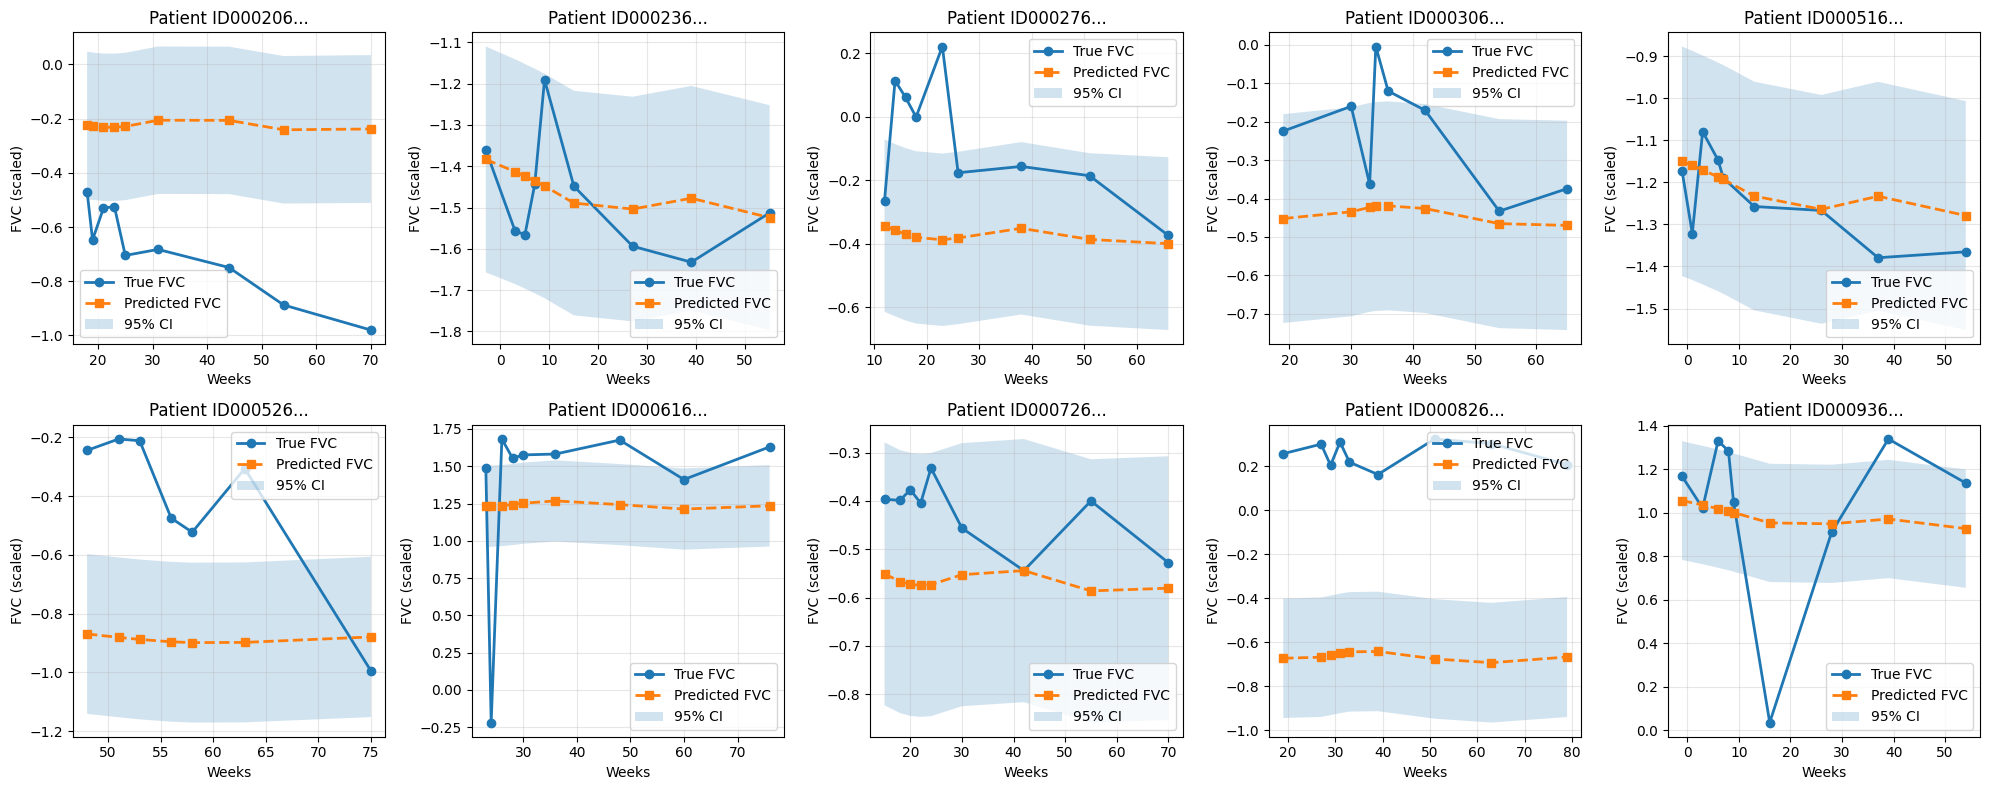

In [9]:
sample_patients = val_df['Patient'].unique()[:10]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, patient_id in enumerate(sample_patients):
    patient_data = val_df[val_df['Patient'] == patient_id].sort_values('Weeks')
    
    # Prepare patient-specific data
    X_time_patient = torch.tensor(patient_data[["Weeks_scaled"]].values, dtype=torch.float32)
    X_age_patient = torch.tensor(patient_data[["Age"]].values, dtype=torch.float32)
    X_baseline_patient = torch.tensor(patient_data[["Baseline_FVC"]].values, dtype=torch.float32)
    sex_patient = torch.tensor(patient_data["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
    smk_patient = torch.tensor(patient_data["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)
    
    # Get predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_patient = likelihood_m2(M2(X_time_patient, X_age_patient, X_baseline_patient, 
                                      sex_patient, smk_patient, use_patient_effects=False))
        y_pred_patient = pred_patient.mean.numpy()
        y_std_patient = pred_patient.variance.sqrt().numpy()
    
    y_true_patient = patient_data["FVC_scaled"].values
    weeks = patient_data["Weeks"].values
    
    # Plot - use consistent 2D indexing
    row = idx // 5
    col = idx % 5
    axes[row, col].plot(weeks, y_true_patient, 'o-', label='True FVC', linewidth=2, markersize=6)
    axes[row, col].plot(weeks, y_pred_patient, 's--', label='Predicted FVC', linewidth=2, markersize=6)
    axes[row, col].fill_between(weeks, 
        y_pred_patient - 2*y_std_patient, 
        y_pred_patient + 2*y_std_patient, 
        alpha=0.2, label='95% CI')
    
    axes[row, col].set_xlabel('Weeks')
    axes[row, col].set_ylabel('FVC (scaled)')
    axes[row, col].set_title(f'Patient {patient_id[:8]}...')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Image Data:

## Approach 1: Late Fusion

For a late fusion approach, two unimodal models, each based on tabular and image data, are combined after inidividual training, in an attempt for them to complement each other in the decision-making process.

Firstly, Gaussian Process (for tabular data) and CNN (for image data) are fused together to complete the multimodal approach.

Loading checkpoint from: c:\Coding\pulmonary_fibrosis\models\checkpoints\cnn_model_20251123_141346.pth
Models loaded successfully!
Tabular stats: {'fvc_mean': 2697.5761750405186, 'fvc_std': 853.7373140549034, 'weeks_mean': 31.055915721231766, 'weeks_std': 23.21059847431442}

Getting CNN predictions for 36 validation patients...
Note: First run may be slow due to DICOM preprocessing and caching


Processing patients: 100%|██████████| 36/36 [00:03<00:00, 11.87it/s]

CNN predictions shape: (315, 1)
CNN predictions for 36 patients

Preparing GP predictions...
GP predictions shape: (315, 1)

Stacking predictions...
Training linear regression for optimal weights...

De-standardizing predictions...

=== Late Fusion Results (Real FVC values) ===
GP Weight: 0.1171
CNN Weight: 1.0079
Intercept: -0.0365

Final MAE: 152.06 ml
Final R²: 0.9205

=== Individual Model Performance (Real FVC values) ===
GP-only MAE: 253.88 ml
GP-only R²: 0.8039
CNN-only MAE: 174.54 ml
CNN-only R²: 0.9038


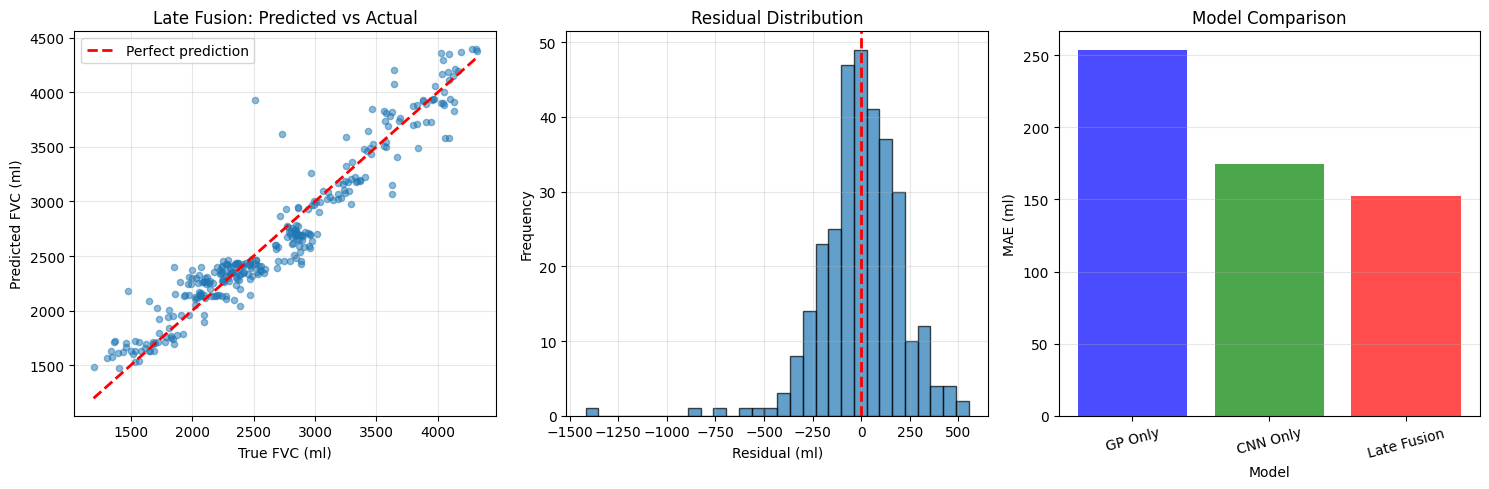

In [11]:
import torch
from torch.utils.data import DataLoader
from models.cnn import CNN, FCLayer, get_scans
from preprocessing.scan.preprocess import get_preprocessed_scan
from preprocessing.tabular_preprocessing import fvc_scaler, time_scaler  
from collections import defaultdict
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model checkpoint
checkpoint_path = BASE_DIR / 'models' / 'checkpoints' / 'cnn_model_20251123_141346.pth'
print(f"Loading checkpoint from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)
tabular_stats = checkpoint['tabular_stats']

# Initialize models
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
cnn_model.load_state_dict(checkpoint['cnn_state_dict'])
fc_model.load_state_dict(checkpoint['fc_state_dict'])

# Set to evaluation mode
cnn_model.eval()
fc_model.eval()

print("Models loaded successfully!")
print(f"Tabular stats: {tabular_stats}")

# Data directory for scans
# data_dir = r'C:\Users\rlaal\Documents\NUS\AY2526S1\CS3244\Project\osic-pulmonary-fibrosis-progression'
data_dir = r'C:\Coding\pulmonary_fibrosis\osic-pulmonary-fibrosis-progression'

val_patient_id_to_initial_FVC = val_df.groupby('Patient')['FVC_scaled'].first().to_dict()
val_patient_id_to_initial_weeks = val_df.groupby('Patient')['Weeks_scaled'].first().to_dict()

val_x, val_y = defaultdict(list), defaultdict(list)
for idx, row in val_df.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks_scaled'], 
        'initial_FVC': val_patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': val_patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC_scaled'])

# Count scans per patient
scan_count = {}
train_dir = os.path.join(data_dir, 'train')
for patient_id in os.listdir(train_dir):
    patient_path = os.path.join(train_dir, patient_id)
    if os.path.isdir(patient_path):
        scan_count[patient_id] = len([f for f in os.listdir(patient_path) if f.endswith('.dcm')])

# Get CNN predictions for validation set
print(f"\nGetting CNN predictions for {len(val_x)} validation patients...")
print("Note: First run may be slow due to DICOM preprocessing and caching")

# REDUCE scan_batch_size from 64 to 16 to speed up significantly
SCAN_BATCH_SIZE = 16  

cnn_val_predictions = []
cnn_val_targets = []

with torch.no_grad():
    for patient_id in tqdm(val_x.keys(), desc="Processing patients"):
        if patient_id not in scan_count:
            print(f"Skipping {patient_id} - no scans found")
            continue
            
        # Load scans
        patient_scan_count = scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, scan_batch_size=SCAN_BATCH_SIZE)
        
        if scans is None:
            print(f"Skipping {patient_id} - failed to load scans")
            continue
        
        # Get image features
        features = cnn_model.forward(scans)
        features = torch.mean(features, dim=0)  # Average across slices
        
        x = val_x[patient_id]
        y = val_y[patient_id]
        
        # Get predictions for each timepoint
        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            cnn_val_predictions.append(output.item())
            cnn_val_targets.append(y[i])

cnn_val_predictions = np.array(cnn_val_predictions).reshape(-1, 1)
cnn_val_targets = np.array(cnn_val_targets)
print(f"CNN predictions shape: {cnn_val_predictions.shape}")
print(f"CNN predictions for {len(set([p for p in val_x.keys() if p in scan_count]))} patients")

# Get GP predictions (already computed above)
print("\nPreparing GP predictions...")
# Match GP predictions to CNN predictions length (same validation set)
gp_val_predictions = y_pred[:len(cnn_val_predictions)].reshape(-1, 1)
y_true_stacked = y_true[:len(cnn_val_predictions)]

print(f"GP predictions shape: {gp_val_predictions.shape}")

# Stack predictions as features (both are in standardized space)
print("\nStacking predictions...")
X_stacked = np.column_stack([gp_val_predictions, cnn_val_predictions])

# Fit linear regression to find optimal weights (in standardized space)
print("Training linear regression for optimal weights...")
lr_model = LinearRegression()
lr_model.fit(X_stacked, y_true_stacked)

# Get final predictions (still in standardized space)
y_final_pred_scaled = lr_model.predict(X_stacked)

print("\nDe-standardizing predictions...")
y_final_pred = fvc_scaler.inverse_transform(y_final_pred_scaled.reshape(-1, 1)).flatten()
y_true_real = fvc_scaler.inverse_transform(y_true_stacked.reshape(-1, 1)).flatten()
cnn_val_predictions_real = fvc_scaler.inverse_transform(cnn_val_predictions).flatten()
cnn_val_targets_real = fvc_scaler.inverse_transform(np.array(cnn_val_targets).reshape(-1, 1)).flatten()
gp_val_predictions_real = fvc_scaler.inverse_transform(gp_val_predictions).flatten()

# Calculate metrics on DE-STANDARDIZED values
mae_final = mean_absolute_error(y_true_real, y_final_pred)
r2_final = r2_score(y_true_real, y_final_pred)

print(f"\n=== Late Fusion Results (Real FVC values) ===")
print(f"GP Weight: {lr_model.coef_[0]:.4f}")
print(f"CNN Weight: {lr_model.coef_[1]:.4f}")
print(f"Intercept: {lr_model.intercept_:.4f}")
print(f"\nFinal MAE: {mae_final:.2f} ml")
print(f"Final R²: {r2_final:.4f}")

# Compare with individual models (de-standardized)
print(f"\n=== Individual Model Performance (Real FVC values) ===")
gp_mae_real = mean_absolute_error(y_true_real, gp_val_predictions_real)
gp_r2_real = r2_score(y_true_real, gp_val_predictions_real)
print(f"GP-only MAE: {gp_mae_real:.2f} ml")
print(f"GP-only R²: {gp_r2_real:.4f}")

cnn_mae = mean_absolute_error(cnn_val_targets_real, cnn_val_predictions_real)
cnn_r2 = r2_score(cnn_val_targets_real, cnn_val_predictions_real)
print(f"CNN-only MAE: {cnn_mae:.2f} ml")
print(f"CNN-only R²: {cnn_r2:.4f}")

# Visualize results (using REAL FVC values)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_true_real, y_final_pred, alpha=0.5, s=20)
plt.plot([y_true_real.min(), y_true_real.max()], 
         [y_true_real.min(), y_true_real.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True FVC (ml)')
plt.ylabel('Predicted FVC (ml)')
plt.title('Late Fusion: Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
residuals_final = y_true_real - y_final_pred
plt.hist(residuals_final, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (ml)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(0, color='r', linestyle='--', lw=2)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
models = ['GP Only', 'CNN Only', 'Late Fusion']
maes = [gp_mae_real, cnn_mae, mae_final]
r2s = [gp_r2_real, cnn_r2, r2_final]

x_pos = np.arange(len(models))
plt.bar(x_pos, maes, alpha=0.7, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('MAE (ml)')
plt.title('Model Comparison')
plt.xticks(x_pos, models, rotation=15)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Approach 2: Early Fusion

For early fusion, we will use a ResNet3D CNN encoder and LSTM encoder for imaging and patient data feature extraction respectively. Afterwards, the outputs from the previous 2 models will be concatenated and fed into a RNN fusion model to train based on the tabular time-series feature.

In [ ]:
import random
from models.joint_fusion_process import jf_validation_results, y_true_list, y_pred_list, y_sigma_list
from evaluation.eval_template import eval_metrics, laplace_log_likelihood


=== Early Fusion Results (Real FVC values) ===

Final MAE: 256.17 ml
Final R²: 0.7911
Laplace Log Likelihood: -7.2619


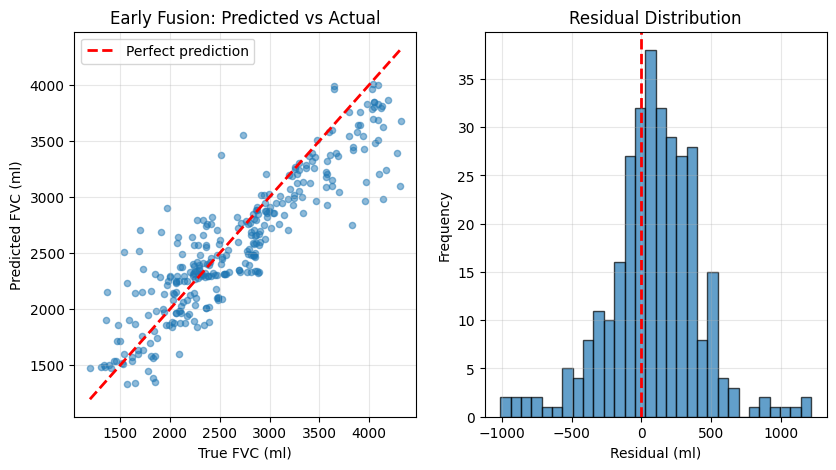

In [4]:
# Calculate metrics for early fusion results
print(f"\n=== Early Fusion Results (Real FVC values) ===")
jf_mae, jf_rmse, jf_r2 = eval_metrics(y_true_list, y_pred_list)
jf_lll = laplace_log_likelihood(y_true_list, y_pred_list, y_sigma_list)
print(f"\nFinal MAE: {jf_mae:.2f} ml")
print(f"Final R²: {jf_r2:.4f}")
print(f"Laplace Log Likelihood: {jf_lll:.4f}")

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_true_list, y_pred_list, alpha=0.5, s=20)
plt.plot([y_true_list.min(), y_true_list.max()], 
         [y_true_list.min(), y_true_list.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True FVC (ml)')
plt.ylabel('Predicted FVC (ml)')
plt.title('Early Fusion: Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
jf_residuals = y_true_list - y_pred_list
plt.hist(jf_residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (ml)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(0, color='r', linestyle='--', lw=2)
plt.grid(True, alpha=0.3)


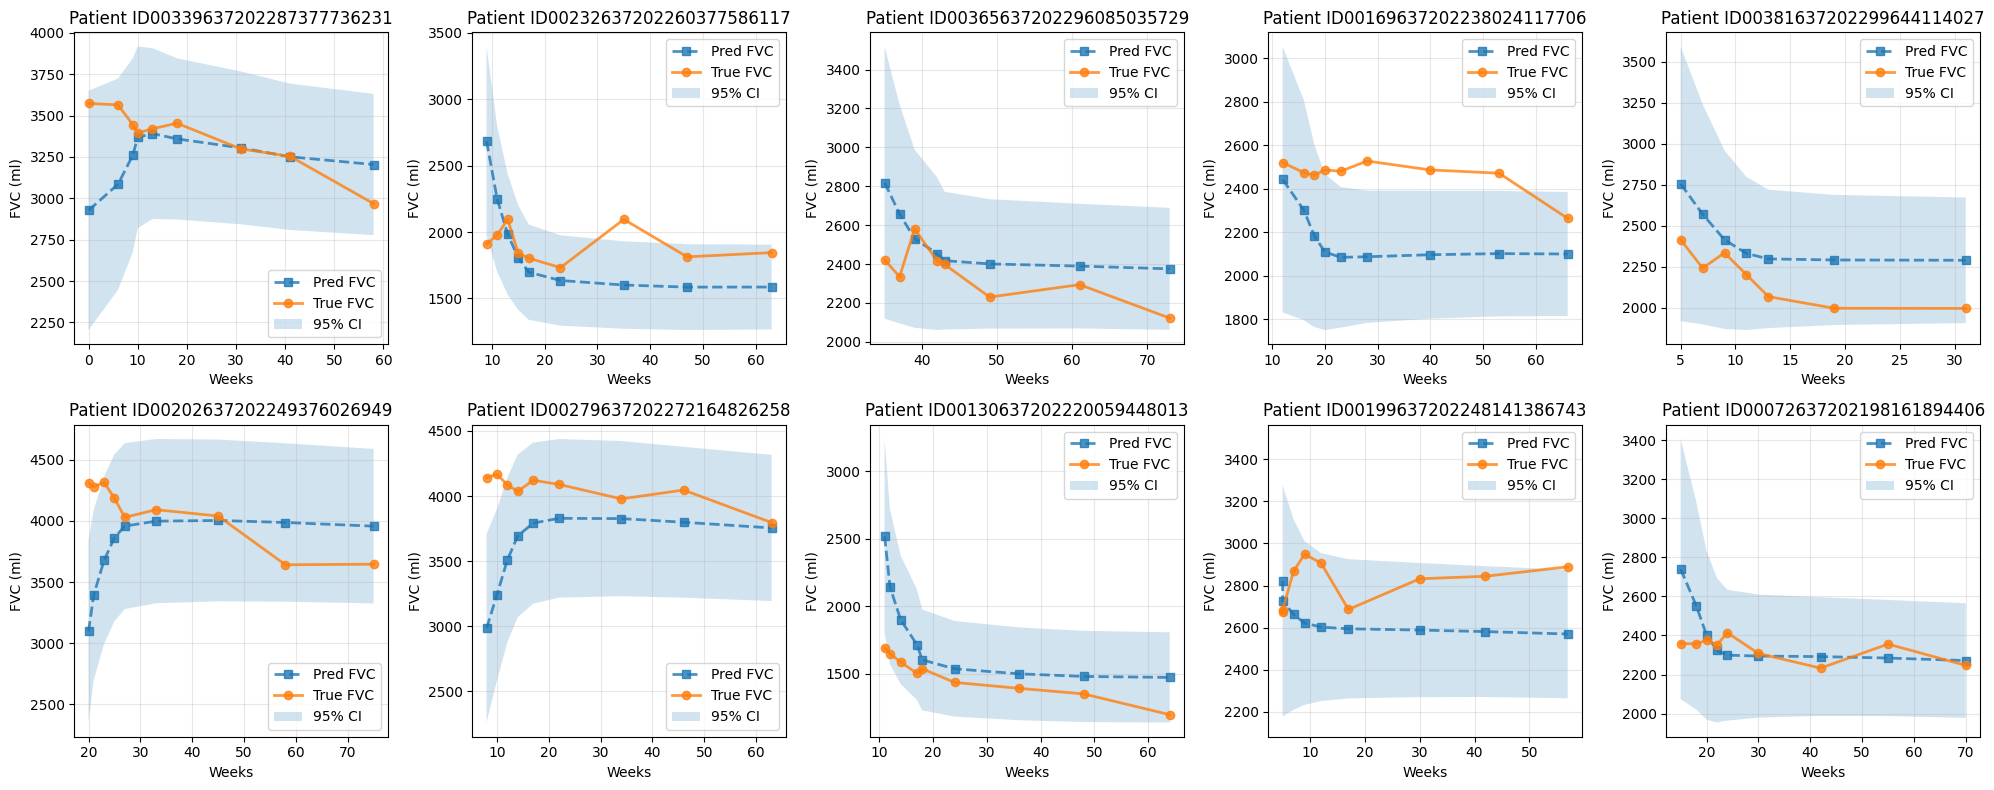

In [6]:
# Visualise results for 10 random validation patients
random_patients = random.sample(list(jf_validation_results.items()), 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, patient_results in enumerate(random_patients):
    patient = patient_results[0]
    weeks = patient_results[1]['weeks']
    y_pred = patient_results[1]['y_pred']
    y_true = patient_results[1]['y_true']
    y_sigma = patient_results[1]['y_sigma']

    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.plot(weeks, y_pred, 's--', alpha=0.8, label='Pred FVC', linewidth=2, markersize=6)
    ax.plot(weeks, y_true, 'o-', alpha=0.8, label='True FVC', linewidth=2, markersize=6)
    ax.fill_between(
        x = weeks,
        y1 = y_pred - 1.96*y_sigma,
        y2 = y_pred + 1.96*y_sigma,
        alpha=0.2,
        label="95% CI"
    )
    ax.set_xlabel('Weeks')
    ax.set_ylabel('FVC (ml)')
    ax.set_title(f'Patient {patient}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()